# **OBJECTIVE :**
# **`Business Case & Hypothesis`**

## >>> <u>Forecast the monthly transactions amount<u>



## Source : Financial Transactions Dataset (www.Kaggle.com)


#### Overview : This comprehensive financial dataset combines transaction records, customer information, and card data from a banking institution, spanning across the 2010s decade.

### Dataset Information

#### <b><u>1. Transaction Data<b><u>

##### * Detailed transaction records including amounts, timestamps, and merchant details
##### * Covers transactions throughout the 2010s
##### * Features transaction types, amounts, and merchant information
##### * Perfect for analyzing spending patterns and building fraud detection models

| Variable      | Description                                                                                                 |
| ------------- | ----------------------------------------------------------------------------------------------------------- |
| id            | ID number of the transaction                                                                                |
| date          | Transction's date                                                                                           |
| client_id     | Client id number                                                                                            |
| card_id       | Card id number                                                                                              |
| amount        | Amount of the transaction                                                                                   |
| use_chip      | Transaction methodology                                                                                     |
| merchant_id   | ID munber of the merchant                                                                                   |
| merchant_city | City of the merchant                                                                                        |
| merchant_state| State of the merchant                                                                                       |
| zip           | Zip code of the merchant                                                                                    |
| mcc           | ID number indicating the category goods or services concerned by the transation                             |
| errors        | Transaction Error                                                                                           |




#### <b><u>2. Merchant Category Codes<b><u>

##### * Standard classification codes for business types
##### * Enables transaction categorization and spending analysis
##### * Industry-standard MCC codes with descriptions

| Variable      | Description                                                                                                 |
| ------------- | ----------------------------------------------------------------------------------------------------------- |
| id            | ID number of the category                                                                                   |                         
| description   | Categorie description                                                                                       |


# <b><span style="color:blue;">1. CONTEXT DESCRIPTION<b>

## **The goal of this project is to forecast the monthly transaction volume based on historical financial data from 2015 to 2019.**

###**After an initial exploratory analysis, I decided to use LightGBM, a gradient boosting algorithm particularly effective for tabular data and capable of efficiently handling categorical features.**


On the below sessions, I used the combo LightGBM + Optuna.

YouTube link where I learned about Optuna : https://www.youtube.com/watch?v=kR9pOvr9Urs&t=1046s

Regarding the machine learning model, I considered two alternatives::

>>> Prophet and LightGBM ; for handling large datasets, I opted for LightGBM.

>>>> Indeed, LightGBM is a decision tree-based Gradient Boosting Framework. LightGBM targets the leaf that shows the greatest ability to minimize total error. Additionnaly, LightGBM trains quickly even in the absence of a GPU.

Following extensive manual hyperparameter testing, I decided to use Optuna.

>>> Optuna is a tool that evaluates various parameters to identify the most effective one.

>>>> I then applied the optimal hyperparameters throughout the machine learning session.





### **Comments :**
The main issue was to obtain reliable predictions while avoiding data leaks and overfitting.

# <b><span style="color:blue;">2. SUCCESSIVE EXPERIMENTS<b>

### **1. Basic Monthly aggregated mode (not in the presentation)**
Approach: Incorporating lag variables (temporal lags) into a monthly dataset.

Outcome: R² ≈ 0.99

Analysis: Data leakage → the model indirectly perceived future values ​​through misaligned lag variables.

### **2. Complete transactions after 2015, including filtering and data smoothing (presentation paragraph 3).**
Approach: Direct the model's attention to uniform years post-2015.

Outcome: R² ≈ -0.010

Analysis: The model is constrained by insufficient context and is not optimized (numerous hours for the machine learning process).

### **3. Comprehensive transactions Post-2015 Filtering enhanced model (slide paragraph 4)**
Approach: Enhancing the model (version 2) by utilizing cache for quicker computations.

Outcome: R² ≈ 0.55

Analysis: The model is producing significantly improved results; however, I believe this time series machine learning model could achieve a better R².

### **4. Monthly aggregated model with temporal split no lag**
Method: Monthly aggregation and temporal split with lag

Outcome: R² ≈ 0.65 on post-2015 data

Analysis:
No data leakage (strict time split)
Very consistent data after 2015 ⇒ predictable model
R² reflects the stability of the series, not overfitting.


## <span style="color:blue;">3. **Experiment 2** simple **cache methodology & data smoothing** - MACHINE LEARNING USING LIGHTGBM

### **Comments :**
In this initial step, I will download and aggregate data to obtain a consolidated DataFrame with all transaction information.
Then I will
1. Import libraries and install Synpase for machine learning purposes
2. Data Extraction and Load - I have extracted data by connecting to Kaggle
3. Spark Session - I have created a Spark Session for big data usage
4. Optuna Setup - I took 1% sample Dataframe and used Optuna to determine the best hyperparameters automatically
5. Creation of the pipeline, LGBM algorithm, temporal split

**Poor Result du to a lack of context : R² ≈ -0.010**

### <b><span style="color:green;">✓</span> <u>Initialization</u></b>

In [ ]:
# -------------------------------------------------------------------------
# 1. Install JAVA - SPARK
# -------------------------------------------------------------------------

!apt-get install openjdk-11-jdk -y
!pip install pyspark==3.5.0
!pip install findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["PATH"] += ":/usr/lib/jvm/java-11-openjdk-amd64/bin"


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  ca-certificates-java fonts-dejavu-core fonts-dejavu-extra java-common
  libatk-wrapper-java libatk-wrapper-java-jni libpcsclite1 libxt-dev libxtst6
  libxxf86dga1 openjdk-11-jdk-headless openjdk-11-jre openjdk-11-jre-headless
  x11-utils
Suggested packages:
  default-jre pcscd libxt-doc openjdk-11-demo openjdk-11-source visualvm
  libnss-mdns fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  | fonts-wqy-zenhei fonts-indic mesa-utils
The following NEW packages will be installed:
  ca-certificates-java fonts-dejavu-core fonts-dejavu-extra java-common
  libatk-wrapper-java libatk-wrapper-java-jni libpcsclite1 libxt-dev libxtst6
  libxxf86dga1 openjdk-11-jdk openjdk-11-jdk-headless openjdk-11-jre
  openjdk-11-jre-headless x11-utils
0 upgraded, 15 newly installed, 0 to remove and 41 not upgraded.
Need to get 122 MB of archives.


In [ ]:
# -------------------------------------------------------------------------
# 2. SPARK Session Initialization
# -------------------------------------------------------------------------

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("ML_Portfolio") \
    .config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:1.0.0") \
    .getOrCreate()

In [ ]:
# -------------------------------------------------------------------------
# 3. Install Synapse Optuna
# -------------------------------------------------------------------------

!pip install synapseml optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 625.8/625.8 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 34.1 MB/s eta 0:00:00


In [ ]:
# -------------------------------------------------------------------------
# 4. Import Libraries
# -------------------------------------------------------------------------

import kagglehub
import pandas as pd
import json
import warnings
import optuna
import lightgbm as lgb
from itertools import product
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, mean, unix_timestamp, to_date, regexp_replace, when, abs,
    dayofweek, month, avg, count, lit
)
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from synapse.ml.lightgbm import LightGBMRegressor

warnings.filterwarnings("ignore")

### <b><span style="color:green;">✓</span> <u>Extraction - Load</u></b>

In [ ]:
# -------------------------------------------------------------------------
# 5. Data Loading
# -------------------------------------------------------------------------

path = kagglehub.dataset_download("computingvictor/transactions-fraud-datasets")
transaction_data = f"{path}/transactions_data.csv"
mcc_codes_data = f"{path}/mcc_codes.json"

td = pd.read_csv(transaction_data)
with open(mcc_codes_data, "r") as f:
    mcc_dict = json.load(f)
mcc = pd.DataFrame.from_dict(mcc_dict, orient="index", columns=["description"]).reset_index().rename(columns={"index": "mcc_code"})

mcc_spark = spark.createDataFrame(mcc)
td_spark = spark.read.csv(transaction_data, header=True, inferSchema=True).cache()

Using Colab cache for faster access to the 'transactions-fraud-datasets' dataset.


### <b><span style="color:green;">✓</span> <u>Data Wrangling</u></b>

In [ ]:
# -------------------------------------------------------------------------
# 6. Data Preparation
# -------------------------------------------------------------------------

LABEL_COL = "amount"
CATEGORICAL_FEATURE_COL = "description"

td_spark = td_spark.withColumn(LABEL_COL, regexp_replace(LABEL_COL, "\$", ""))
td_spark = td_spark.withColumn(LABEL_COL, col(LABEL_COL).cast(DoubleType()))
td_spark = td_spark.withColumn("date", to_date("date"))

df = td_spark.join(mcc_spark, td_spark.mcc == mcc_spark.mcc_code, "left")
df = df.drop("id", "client_id", "card_id", "use_chip", "merchant_id", "merchant_city",
             "merchant_state", "zip", "mcc", "errors", "mcc_code")

df = df.withColumn("date_timestamp", unix_timestamp(col("date")).cast(DoubleType()))
df = df.withColumn("day_of_week", dayofweek(col("date")).cast(DoubleType()))
df = df.withColumn("month", month(col("date")).cast(DoubleType()))
df = df.withColumn("is_refund", when(col(LABEL_COL) < 0, 1.0).otherwise(0.0).cast(DoubleType()))
df = df.withColumn(LABEL_COL, when(col(LABEL_COL).isNull(), 0.0).otherwise(abs(col(LABEL_COL))))

CLEANED_CATEGORICAL_COL = "description_clean"
df = df.withColumn(CLEANED_CATEGORICAL_COL, regexp_replace(col(CATEGORICAL_FEATURE_COL), "[ ,:\\[\\]\\{\\}]", "_"))

In [ ]:
# -------------------------------------------------------------------------
# 7. Sample (1%) will be used to search the best hyper parameters settings
# -------------------------------------------------------------------------

df_sample = df.sample(fraction=0.01, seed=42).toPandas()
df_sample.dropna(subset=[LABEL_COL], inplace=True)
df_sample["date_timestamp"] = pd.to_datetime(df_sample["date"]).astype(int) / 10**9
df_sample["is_refund"] = (df_sample[LABEL_COL] < 0).astype(float)
df_sample[LABEL_COL] = df_sample[LABEL_COL].abs()

X = df_sample[["date_timestamp", "is_refund"]]
y = df_sample[LABEL_COL]

In [ ]:
# -------------------------------------------------------------------------
# 8. Bayesian Optimization to find the best hyper parameters settings - Using OPTUNA
# -------------------------------------------------------------------------

def objective(trial):
    params = {
        "objective": "regression",
        "metric": "rmse",
        "num_leaves": trial.suggest_int("num_leaves", 31, 256),
        "max_depth": trial.suggest_int("max_depth", 5, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.7, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.7, 1.0),
        "num_iterations": trial.suggest_int("num_iterations", 200, 1000),
        "verbose": -1,
        "seed": 42
    }

    train_data = lgb.Dataset(X, label=y)
    model = lgb.train(params, train_data)
    preds = model.predict(X)
    rmse = ((preds - y) ** 2).mean() ** 0.5
    return rmse

print("\n Optimization starting on 1% sample...")
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=25)
best_params = study.best_params
print(f"Best Hyperparameters :\n{best_params}")

[I 2025-11-01 18:18:06,922] A new study created in memory with name: no-name-57a4e1da-1bf0-4ba7-8482-79364ff98811



 Optimization starting on 1% sample...


[I 2025-11-01 18:18:24,572] Trial 0 finished with value: 75.33336139121394 and parameters: {'num_leaves': 153, 'max_depth': 15, 'learning_rate': 0.022079166749651016, 'feature_fraction': 0.9887256591512779, 'bagging_fraction': 0.7694494483051384, 'num_iterations': 506}. Best is trial 0 with value: 75.33336139121394.
[I 2025-11-01 18:18:33,982] Trial 1 finished with value: 75.33516233772073 and parameters: {'num_leaves': 48, 'max_depth': 13, 'learning_rate': 0.0165253572023927, 'feature_fraction': 0.9925144157806065, 'bagging_fraction': 0.8878605938404487, 'num_iterations': 497}. Best is trial 0 with value: 75.33336139121394.
[I 2025-11-01 18:18:49,723] Trial 2 finished with value: 75.33334662373754 and parameters: {'num_leaves': 233, 'max_depth': 12, 'learning_rate': 0.05165046435797901, 'feature_fraction': 0.8094348887352868, 'bagging_fraction': 0.7693234761306247, 'num_iterations': 633}. Best is trial 2 with value: 75.33334662373754.
[I 2025-11-01 18:18:53,162] Trial 3 finished with 

Best Hyperparameters :
{'num_leaves': 171, 'max_depth': 9, 'learning_rate': 0.09787165282999918, 'feature_fraction': 0.7008019787226754, 'bagging_fraction': 0.7855886049211697, 'num_iterations': 1000}


### <b><span style="color:green;">✓</span> <u>Machine Learning</u></b>

In [ ]:
# -------------------------------------------------------------------------
# 9. Rolling validation Spark with best hyperparameters found
# -------------------------------------------------------------------------
def target_encode(train_df, test_df, categorical_col, target_col, smoothing=100.0):
    global_mean = train_df.select(avg(col(target_col))).collect()[0][0]
    agg = train_df.groupBy(categorical_col).agg(
        avg(col(target_col)).alias("mean_category"),
        count(col(target_col)).alias("count_category")
    )
    agg = agg.withColumn(
        "mean_encoded",
        (col("mean_category") * col("count_category") + lit(global_mean) * lit(smoothing))
        / (col("count_category") + lit(smoothing))
    ).select(categorical_col, "mean_encoded")

    train_encoded = train_df.join(agg, on=categorical_col, how="left").na.fill({"mean_encoded": global_mean})
    test_encoded = test_df.join(agg, on=categorical_col, how="left").na.fill({"mean_encoded": global_mean})
    return train_encoded, test_encoded


def train_with_best_params(train_df, test_df, params):
    final_features = ["date_timestamp", "day_of_week", "month", "is_refund", "mean_encoded"]
    assembler = VectorAssembler(inputCols=final_features, outputCol="features_vector")
    pipeline = Pipeline(stages=[assembler])
    pipeline_model = pipeline.fit(train_df)
    train_data = pipeline_model.transform(train_df)
    test_data = pipeline_model.transform(test_df)

    lgbm = LightGBMRegressor(
        featuresCol="features_vector",
        labelCol=LABEL_COL,
        objective="regression",
        numLeaves=params["num_leaves"],
        maxDepth=params["max_depth"],
        learningRate=params["learning_rate"],
        featureFraction=params["feature_fraction"],
        baggingFraction=params["bagging_fraction"],
        numIterations=params["num_iterations"]
    )

    model = lgbm.fit(train_data)
    preds = model.transform(test_data)

    evaluator = RegressionEvaluator(labelCol=LABEL_COL, predictionCol="prediction")
    metrics = {
        "mse": evaluator.evaluate(preds, {evaluator.metricName: "mse"}),
        "rmse": evaluator.evaluate(preds, {evaluator.metricName: "rmse"}),
        "mae": evaluator.evaluate(preds, {evaluator.metricName: "mae"}),
        "r2": evaluator.evaluate(preds, {evaluator.metricName: "r2"}),
    }
    return metrics

#split_years = [2015, 2016, 2017, 2018]
split_years = [2018]
results = []

for year in split_years:
    split_date = f"{year}-12-31"
    print(f"\n Temporal Split : Train ≤ {split_date} | Test > {split_date}")

    train_df = df.filter(col("date") <= split_date)
    test_df = df.filter(col("date") > split_date)

    if train_df.count() == 0 or test_df.count() == 0:
        print(f"Not enough data for the year : {year}.")
        continue

    train_encoded, test_encoded = target_encode(train_df, test_df, CLEANED_CATEGORICAL_COL, LABEL_COL)
    metrics = train_with_best_params(train_encoded, test_encoded, best_params)
    metrics["train_end"] = year
    metrics["test_year"] = year + 1

    print(f"Résultats {year+1} → R² = {metrics['r2']:.4f} | RMSE = {metrics['rmse']:.2f}")
    results.append(metrics)


 Temporal Split : Train ≤ 2018-12-31 | Test > 2018-12-31
Résultats 2019 → R² = -0.0106 | RMSE = 74.78


In [ ]:
# -------------------------------------------------------------------------
# 10. Final Export
# -------------------------------------------------------------------------
results_df = pd.DataFrame(results)
results_df.to_csv("ML_Portfolio.csv", index=False)
print("\nExport done 'ML_Portfolio'")
print(results_df)


Export done 'ML_Portfolio'
           mse       rmse        mae        r2  train_end  test_year
0  5592.309422  74.781745  44.413696 -0.010614       2018       2019


**Below the performance indicators result for 2015 - 2018:**

| mse           | rmse       |  mae       | r2         |  train year | test year |
| ------------- | -----------|------------|------------|-------------|-----------|
| 5706.459224   | 75.027384  | 43.473863  | -0.005715  | 2015        | 2016      |
| 5808.157885   | 76.211271  | 47.710919  | -0.043708  | 2016        | 2017      |
| 5706.459224   | 75.541109  | 46.136135  | -0.025676  | 2017        | 2018      |
| 5592.319461   | 74.781812  | 44.413757  | -0.010614  | 2018        | 2019      |

In addition to the earlier analysis conducted, **a trend shift occurred in 2015**. It clarifies the **'weak' R² outcome in 2015.**

In **2016**, the **R² improved 100-fold** *compared to 2015*, suggesting that the LightGBM algorithm has learned. And the R² for 2017 is expected to rise.

In **2017**, **the R² improved to twice the value of 2016**; nonetheless, it **remains quite low** and can even be negative.

In **2018**, I observe a **similar situation as in 2017**, with a slight rise in **R², yet it remains very low**.

### **Comments :**

Let's verify if the performance indicator is due to the trend shift in 2015.
So I will filter the Dataframe with data from 2015.

## <span style="color:blue;">4. **Experiment 3** Using cache methodology without data smoothing - MACHINE LEARNING USING LIGHTGBM

### <b><span style="color:green;">✓</span> <u>Initialization</u></b>

In [ ]:
# -------------------------------------------------------------------------
# 1. Install JAVA - SPARK
# -------------------------------------------------------------------------

!apt-get install openjdk-11-jdk -y
!pip install pyspark==3.5.0
!pip install findspark
!pip install --force-reinstall numpy==1.26.4 pandas==2.2.2

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["PATH"] += ":/usr/lib/jvm/java-11-openjdk-amd64/bin"


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
openjdk-11-jdk is already the newest version (11.0.28+6-1ubuntu1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached pandas-2.2.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached six-1.17.0-py2.py3-none-any.whl.metadata (1.7 kB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
Using cached pandas-2.2.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.7 MB)
Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl (229 kB)
Using cached py

In [ ]:
# -------------------------------------------------------------------------
# 2. Spark Configuration
# -------------------------------------------------------------------------

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("ML_Portfolio_After_2015") \
    .config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:1.0.0") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.default.parallelism", "200") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

In [ ]:
# -------------------------------------------------------------------------
# 3. Install Synapse Optuna
# -------------------------------------------------------------------------

!pip install synapseml optuna

In [ ]:
# -------------------------------------------------------------------------
# 4. Import Libraries
# -------------------------------------------------------------------------

import kagglehub
import pandas as pd
import json
import warnings
import optuna
import lightgbm as lgb
from pyspark.sql.functions import (
    col, mean, unix_timestamp, to_date, regexp_replace, when, abs,
    dayofweek, month, sum, avg, count, lit, isnan, countDistinct, stddev
)
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.linalg import DenseVector
from synapse.ml.lightgbm import LightGBMRegressor

warnings.filterwarnings("ignore")

### <b><span style="color:green;">✓</span> <u>Extraction - Load</u></b>

In [ ]:
# -------------------------------------------------------------------------
# 5. Data Loading
# -------------------------------------------------------------------------

path = kagglehub.dataset_download("computingvictor/transactions-fraud-datasets")
transaction_data = f"{path}/transactions_data.csv"
mcc_codes_data = f"{path}/mcc_codes.json"

with open(mcc_codes_data, "r") as f:
    mcc_dict = json.load(f)
mcc = pd.DataFrame.from_dict(mcc_dict, orient="index", columns=["description"]).reset_index().rename(columns={"index": "mcc_code"})

mcc_spark = spark.createDataFrame(mcc)
td_spark = spark.read.csv(transaction_data, header=True, inferSchema=True)

Using Colab cache for faster access to the 'transactions-fraud-datasets' dataset.


### <b><span style="color:green;">✓</span> <u>Data Wrangling</u></b>

In [ ]:
# -------------------------------------------------------------------------
# 6. Feature Engineering
# -------------------------------------------------------------------------

LABEL_COL = "amount"
CATEGORICAL_FEATURE_COL = "description"
CLEANED_CATEGORICAL_COL = "description_clean"

td_spark = td_spark.withColumn(LABEL_COL, regexp_replace(LABEL_COL, "\$", ""))
td_spark = td_spark.withColumn(LABEL_COL, col(LABEL_COL).cast(DoubleType()))
td_spark = td_spark.withColumn("date", to_date("date"))

df = td_spark.join(mcc_spark, td_spark.mcc == mcc_spark.mcc_code, "left")
df = df.drop("id", "client_id", "card_id", "use_chip", "merchant_id", "merchant_city",
             "merchant_state", "zip", "mcc", "errors", "mcc_code")

df = df.withColumn("date_timestamp", unix_timestamp(col("date")).cast(DoubleType()))
df = df.withColumn("day_of_week", dayofweek(col("date")).cast(DoubleType()))
df = df.withColumn("month", month(col("date")).cast(DoubleType()))
df = df.withColumn("is_refund", when(col(LABEL_COL) < 0, 1.0).otherwise(0.0).cast(DoubleType()))
df = df.withColumn(LABEL_COL, when(col(LABEL_COL).isNull(), 0.0).otherwise(abs(col(LABEL_COL))))
df = df.withColumn(CLEANED_CATEGORICAL_COL, regexp_replace(col(CATEGORICAL_FEATURE_COL), "[ ,:\\[\\]\\{\\}]", "_"))

# Filter period of interest
df = df.filter((col("date") >= "2015-01-01") & (col("date") <= "2019-10-31"))
df = df.cache()
print(f"Dataset loaded : {df.count():,} rows")

Dataset loaded : 6,734,248 rows


In [ ]:
# -------------------------------------------------------------------------
# 7. Target Encoding
# -------------------------------------------------------------------------

def target_encode_optimized(train_df, test_df, cat_col, label_col):
    # Calcul of average per category
    mean_encoding = train_df.groupBy(cat_col).agg(avg(label_col).alias("mean_encoded"))
    mean_encoding = mean_encoding.cache()
    mean_encoding.count()

    # Global Average for empty or unknown values
    global_mean = train_df.select(avg(label_col)).collect()[0][0]

    # Joining train tables
    train_encoded = train_df.join(mean_encoding, cat_col, "left") \
        .withColumn("mean_encoded", when(col("mean_encoded").isNull(), global_mean).otherwise(col("mean_encoded")))

    test_encoded = test_df.join(mean_encoding, cat_col, "left") \
        .withColumn("mean_encoded", when(col("mean_encoded").isNull(), global_mean).otherwise(col("mean_encoded")))

    # Return as Spark DataFrames
    return train_encoded, test_encoded


In [ ]:
# -------------------------------------------------------------------------
# 8. Bayesian Optimization (Automatic best hyperparameters) base on 1% data sample
# -------------------------------------------------------------------------

FEATURES_COL = [
    "date_timestamp", "day_of_week", "month", "is_refund",
    CLEANED_CATEGORICAL_COL
]

# Creation 1% sample
sample_df = df.sample(False, 0.01, seed=42)
sample_pd = sample_df.toPandas()

# Vérifie que la colonne catégorielle existe, sinon tente de la récupérer
if CLEANED_CATEGORICAL_COL not in sample_pd.columns and CATEGORICAL_FEATURE_COL in sample_pd.columns:
    sample_pd[CLEANED_CATEGORICAL_COL] = sample_pd[CATEGORICAL_FEATURE_COL]

# Si la colonne catégorielle existe, on la convertit en catégorie
if CLEANED_CATEGORICAL_COL in sample_pd.columns:
    sample_pd[CLEANED_CATEGORICAL_COL] = sample_pd[CLEANED_CATEGORICAL_COL].astype("category")
    sample_pd[f"{CLEANED_CATEGORICAL_COL}_code"] = sample_pd[CLEANED_CATEGORICAL_COL].cat.codes
    sample_features = ["date_timestamp", "day_of_week", "month", "is_refund", f"{CLEANED_CATEGORICAL_COL}_code"]
else:
    sample_features = ["date_timestamp", "day_of_week", "month", "is_refund"]

X = sample_pd[sample_features]
y = sample_pd[LABEL_COL]

# ----------------------------------------------------
# Optuna objective function
# ----------------------------------------------------
def objective(trial):
    params = {
        "objective": "regression",
        "metric": "rmse",
        "num_leaves": trial.suggest_int("num_leaves", 31, 256),
        "max_depth": trial.suggest_int("max_depth", 5, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.7, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.7, 1.0),
        "num_iterations": trial.suggest_int("num_iterations", 200, 1000),
        "verbose": -1,
        "seed": 42
    }

    train_data = lgb.Dataset(X, label=y)
    model = lgb.train(params, train_data)
    preds = model.predict(X)
    rmse = ((preds - y) ** 2).mean() ** 0.5
    return rmse

# ----------------------------------------------------
# Run optimization
# ----------------------------------------------------
print("\nOptuna Optimization start on 1% data sample...")
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=20)
best_params = study.best_params
print(f"Best hyperparameters:\n{best_params}")

[I 2025-11-03 12:52:17,982] A new study created in memory with name: no-name-58c54689-9de5-497f-8446-dda4951e6ef4



Optuna Optimization start on 1% data sample...


[I 2025-11-03 12:52:21,139] Trial 0 finished with value: 51.0878380411952 and parameters: {'num_leaves': 115, 'max_depth': 15, 'learning_rate': 0.05395030966670229, 'feature_fraction': 0.8795975452591109, 'bagging_fraction': 0.7468055921327309, 'num_iterations': 324}. Best is trial 0 with value: 51.0878380411952.
[I 2025-11-03 12:52:29,643] Trial 1 finished with value: 50.91268696034915 and parameters: {'num_leaves': 44, 'max_depth': 14, 'learning_rate': 0.039913058785616795, 'feature_fraction': 0.9124217733388136, 'bagging_fraction': 0.7061753482887407, 'num_iterations': 976}. Best is trial 1 with value: 50.91268696034915.
[I 2025-11-03 12:52:35,277] Trial 2 finished with value: 56.89118695944336 and parameters: {'num_leaves': 219, 'max_depth': 7, 'learning_rate': 0.015199348301309814, 'feature_fraction': 0.7550213529560301, 'bagging_fraction': 0.7912726728878613, 'num_iterations': 620}. Best is trial 1 with value: 50.91268696034915.
[I 2025-11-03 12:52:41,472] Trial 3 finished with v

Best hyperparameters:
{'num_leaves': 251, 'max_depth': 11, 'learning_rate': 0.09862929796873673, 'feature_fraction': 0.9911190152534857, 'bagging_fraction': 0.9069671270049076, 'num_iterations': 792}


### <b><span style="color:green;">✓</span> <u>Machine Learning</u></b>

In [ ]:
# -------------------------------------------------------------------------
# 9. Optimized train data
# -------------------------------------------------------------------------

# The previous model was really slow. The purpose of the new optimized version below is to decrease the training duration.

def train_with_best_params_optimized(train_df, test_df, params):
    final_features = ["date_timestamp", "day_of_week", "month", "is_refund", "mean_encoded"]

    # Verification of columns in training dataframe
    for c in final_features + [LABEL_COL]:
        if c not in train_df.columns:
            raise ValueError(f"Missing column {c} in training data")

    # OPTIMISATION 1 : Cleaning and push it to cache
    def clean_and_cache(dframe):
        df_local = dframe
        for c in final_features + [LABEL_COL]:
            df_local = df_local.filter(~isnan(col(c)) & col(c).isNotNull())
        df_local = df_local.cache()
        return df_local

    train_df = clean_and_cache(train_df)
    test_df = clean_and_cache(test_df)

    # OPTIMISATION 2 : Verification of the data volume
    train_count = train_df.count()
    if train_count < 1000:
        print("Too small dataframe, split ignored")
        train_df.unpersist()
        test_df.unpersist()
        return {"mse": None, "rmse": None, "mae": None, "r2": None}

    # OPTIMISATION 3 : Variance check
    stats_df = train_df.select([countDistinct(col(f)).alias(f"distinct_{f}") for f in final_features] +
                                [stddev(col(f)).alias(f"std_{f}") for f in final_features])
    stats = stats_df.collect()[0].asDict()

    valid_features = []
    for f in final_features:
        unique_val = stats.get(f"distinct_{f}", 0)
        std_val = stats.get(f"std_{f}", None)
        if unique_val is not None and unique_val > 1 and std_val is not None and std_val > 0:
            valid_features.append(f)
        else:
            print(f"Feature '{f}' deleted due to null variance or single value")

    if len(valid_features) == 0:
        print("No valid feature, ignored split.")
        train_df.unpersist()
        test_df.unpersist()
        return {"mse": None, "rmse": None, "mae": None, "r2": None}

    # Assembler
    assembler = VectorAssembler(inputCols=valid_features, outputCol="features_vector", handleInvalid="skip")
    pipeline = Pipeline(stages=[assembler])
    pipeline_model = pipeline.fit(train_df)

    train_data = pipeline_model.transform(train_df).cache()
    test_data = pipeline_model.transform(test_df).cache()

    # OPTIMISATION 4 : Vector verification
    sample_check = train_data.select("features_vector").limit(10).collect()
    if len(sample_check) == 0:
        print("No data after transformation")
        train_df.unpersist()
        test_df.unpersist()
        train_data.unpersist()
        test_data.unpersist()
        return {"mse": None, "rmse": None, "mae": None, "r2": None}

    # LightGBM optimized hyperparameters (SynapseML LightGBMRegressor)
    lgbm = LightGBMRegressor(
        featuresCol="features_vector",
        labelCol=LABEL_COL,
        objective="regression",
        numLeaves=int(params.get("num_leaves", 31)),
        maxDepth=int(params.get("max_depth", 6)),
        learningRate=float(params.get("learning_rate", 0.1)),
        featureFraction=float(params.get("feature_fraction", 1.0)),
        baggingFraction=float(params.get("bagging_fraction", 1.0)),
        numIterations=int(params.get("num_iterations", 100)),
        verbosity=-1,
        numThreads=4,
    )

    print(f"Training on {train_count:,} rows...")
    model = lgbm.fit(train_data)
    preds = model.transform(test_data)

    evaluator = RegressionEvaluator(labelCol=LABEL_COL, predictionCol="prediction")
    metrics = {
        "mse": evaluator.evaluate(preds, {evaluator.metricName: "mse"}),
        "rmse": evaluator.evaluate(preds, {evaluator.metricName: "rmse"}),
        "mae": evaluator.evaluate(preds, {evaluator.metricName: "mae"}),
        "r2": evaluator.evaluate(preds, {evaluator.metricName: "r2"}),
    }

    # Cleaning memory
    train_df.unpersist()
    test_df.unpersist()
    train_data.unpersist()
    test_data.unpersist()

    return metrics

In [ ]:
# -------------------------------------------------------------------------
# 8. Rolling Temporal Validation OPTIMISÉ
# -------------------------------------------------------------------------

split_years = [2015, 2016, 2017, 2018]
results = []

for split_year in split_years:
    split_date = f"{split_year}-12-31"
    print(f"\n{'='*60}")
    print(f"Temporal Split : Train ≤ {split_date} | Test > {split_date}")
    print(f"{'='*60}")

    # OPTIMISATION 5 : Filter and push to cache
    train_df = df.filter(col("date") <= split_date).cache()
    test_df = df.filter(col("date") > split_date).cache()

    train_count = train_df.count()
    test_count = test_df.count()

    print(f"Train: {train_count:,} | Test: {test_count:,}")

    if train_count < 1000 or test_count < 1000:
        print(f"Not enough data for year {split_year}, skipping...")
        train_df.unpersist()
        test_df.unpersist()
        continue

    # Target Encoding
    print(f"Target encoding...")
    train_encoded, test_encoded = target_encode_optimized(train_df, test_df, CLEANED_CATEGORICAL_COL, LABEL_COL)
    train_encoded = train_encoded.cache()
    test_encoded = test_encoded.cache()

    # Training
    metrics = train_with_best_params_optimized(train_encoded, test_encoded, best_params)

    # Defensive: ensure metrics is a dict
    if not isinstance(metrics, dict):
        # Try to convert if it's a tuple/list with expected order; otherwise wrap
        if isinstance(metrics, (tuple, list)) and len(metrics) >= 4:
            metrics = {
                "mse": metrics[0],
                "rmse": metrics[1],
                "mae": metrics[2],
                "r2": metrics[3]
            }
        else:
            metrics = {"mse": None, "rmse": None, "mae": None, "r2": None}
            print("Warning: metrics returned an unexpected type; normalized to None values.")

    # Add metadata about split
    metrics["train_end"] = split_year
    metrics["test_year"] = split_year + 1

    if metrics["r2"] is not None:
        print(f"Result {split_year+1} → R² = {metrics['r2']:.4f} | RMSE = {metrics['rmse']:.2f}")

    results.append(metrics)

    # Cleaning
    train_df.unpersist()
    test_df.unpersist()
    # target_encode returned cached objects
    try:
        train_encoded.unpersist()
        test_encoded.unpersist()
    except Exception:
        pass

# Final results DataFrame
results_df = pd.DataFrame(results)
print("\nFinal results:")
print(results_df)


Temporal Split : Train ≤ 2015-12-31 | Test > 2015-12-31
Train: 1,388,065 | Test: 5,346,183
Target encoding...
Training on 1,388,065 rows...
Result 2016 → R² = 0.5509 | RMSE = 50.13

Temporal Split : Train ≤ 2016-12-31 | Test > 2016-12-31
Train: 2,780,182 | Test: 3,954,066
Target encoding...
Training on 2,780,182 rows...
Result 2017 → R² = 0.5542 | RMSE = 49.81

Temporal Split : Train ≤ 2017-12-31 | Test > 2017-12-31
Train: 4,179,490 | Test: 2,554,758
Target encoding...
Training on 4,179,490 rows...
Result 2018 → R² = 0.5547 | RMSE = 49.77

Temporal Split : Train ≤ 2018-12-31 | Test > 2018-12-31
Train: 5,574,282 | Test: 1,159,966
Target encoding...
Training on 5,574,282 rows...
Result 2019 → R² = 0.5530 | RMSE = 49.74

Final results:
           mse       rmse        mae        r2  train_end  test_year
0  2513.398113  50.133802  29.311969  0.550948       2015       2016
1  2480.598657  49.805609  29.263845  0.554244       2016       2017
2  2477.255706  49.772037  29.204425  0.554739   

In [ ]:
# -------------------------------------------------------------------------
# 8. Display final Results
# -------------------------------------------------------------------------

print(f"\n{'='*60}")
print("FINAL RESULT")
print(f"{'='*60}")

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

# Metrics
valid_results = results_df[results_df['r2'].notna()]
if len(valid_results) > 0:
    print(f"\n Average on {len(valid_results)} years:")
    print(f" Average R² : {valid_results['r2'].mean():.4f}")
    print(f" Average RMSE : {valid_results['rmse'].mean():.2f}")
    print(f" Average MAE : {valid_results['mae'].mean():.2f}")


FINAL RESULT
        mse      rmse       mae       r2  train_end  test_year
2513.398113 50.133802 29.311969 0.550948       2015       2016
2480.598657 49.805609 29.263845 0.554244       2016       2017
2477.255706 49.772037 29.204425 0.554739       2017       2018
2473.638377 49.735685 29.221757 0.552976       2018       2019

 Average on 4 years:
 Average R² : 0.5532
 Average RMSE : 49.86
 Average MAE : 29.25


### **Comments :**

As planned by filtering the dataframe after 2015, the result is much better.
However, an R² of 0.55 is not enough satisfying in my opinion.

To obtain better results, there is 2 options:
>>> **Add addtional data** for the LightGBM algorithm to gain more insights

>>> Go back on the first version and **aggregate data** on a monthly periodicity.

Let's return to the first needs: Predict the monthly transaction amount (high level view).
So For the next experiment, I will revisit the initial idea and aggregate data without lag.

## <span style="color:blue;">5. **Experiment 4** with Monthly aggregation - MACHINE LEARNING USING LIGHTGBM

### <b><span style="color:green;">✓</span> <u>Initialization</u></b>

In [ ]:
# -------------------------------------------------------------------------
# 1. Install JAVA - SPARK
# -------------------------------------------------------------------------

!apt-get install openjdk-11-jdk -y
!pip install pyspark==3.5.0
!pip install findspark
!pip install --force-reinstall numpy==1.26.4 pandas==2.2.2

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["PATH"] += ":/usr/lib/jvm/java-11-openjdk-amd64/bin"



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  ca-certificates-java fonts-dejavu-core fonts-dejavu-extra java-common
  libatk-wrapper-java libatk-wrapper-java-jni libpcsclite1 libxt-dev libxtst6
  libxxf86dga1 openjdk-11-jdk-headless openjdk-11-jre openjdk-11-jre-headless
  x11-utils
Suggested packages:
  default-jre pcscd libxt-doc openjdk-11-demo openjdk-11-source visualvm
  libnss-mdns fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  | fonts-wqy-zenhei fonts-indic mesa-utils
The following NEW packages will be installed:
  ca-certificates-java fonts-dejavu-core fonts-dejavu-extra java-common
  libatk-wrapper-java libatk-wrapper-java-jni libpcsclite1 libxt-dev libxtst6
  libxxf86dga1 openjdk-11-jdk openjdk-11-jdk-headless openjdk-11-jre
  openjdk-11-jre-headless x11-utils
0 upgraded, 15 newly installed, 0 to remove and 41 not upgraded.
Need to get 122 MB of archives.


In [ ]:
# ----------------------
# 2. Spark init
# ----------------------

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("ML_Portfolio_Monthly_Aggregated_Prediction") \
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()

In [ ]:
# -------------------------------------------------------------------------
# 3. Install Synapse Optuna
# -------------------------------------------------------------------------

!pip install synapseml optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 625.8/625.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 14.6 MB/s eta 0:00:00


In [ ]:
# -------------------------------------------------------------------------
# 4. Import Libraries
# -------------------------------------------------------------------------

import kagglehub
import pandas as pd
import numpy as np
import json
import warnings
import optuna
import lightgbm as lgb
from math import pi
from pyspark.sql.functions import (
    col, to_date, regexp_replace, unix_timestamp, dayofweek, month, year, sin, cos, lit,
    sum as _sum, avg as _avg, count as _count, stddev as _stddev, countDistinct,
    when, expr, max as _max
)
from pyspark.sql.types import DoubleType, IntegerType
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import sklearn.metrics

warnings.filterwarnings("ignore")

### <b><span style="color:green;">✓</span> <u>Extraction - Load</u></b>

In [ ]:
# -------------------------------------------------------------------------
# 5. Data Loading
# -------------------------------------------------------------------------

path = kagglehub.dataset_download("computingvictor/transactions-fraud-datasets")
transaction_data = f"{path}/transactions_data.csv"
mcc_codes_data = f"{path}/mcc_codes.json"

# load mcc descriptions
with open(mcc_codes_data, "r") as f:
    mcc_dict = json.load(f)
mcc = pd.DataFrame.from_dict(mcc_dict, orient="index", columns=["description"]) \
    .reset_index().rename(columns={"index": "mcc_code"})
mcc_spark = spark.createDataFrame(mcc)

# load transactions
td_spark = spark.read.csv(transaction_data, header=True, inferSchema=True)



100%|██████████| 348M/348M [00:02<00:00, 138MB/s]

Extracting files...


### <b><span style="color:green;">✓</span> <u>Data Wrangling</u></b>

In [ ]:
# -------------------------------------------------------------------------
# 6. Feature Engineering
# -------------------------------------------------------------------------

LABEL_COL = "amount"

td_spark = td_spark.withColumn(LABEL_COL, regexp_replace(col(LABEL_COL), "\\$", ""))
td_spark = td_spark.withColumn(LABEL_COL, col(LABEL_COL).cast(DoubleType()))
td_spark = td_spark.withColumn("date", to_date(col("date")))

df = td_spark.join(mcc_spark, td_spark.mcc == mcc_spark.mcc_code, "left")

cols_to_drop = ["id", "use_chip", "merchant_city", "merchant_state", "zip", "mcc", "errors", "mcc_code"]
for c in cols_to_drop:
    if c in df.columns:
        df = df.drop(c)

df = df.withColumn("year", year(col("date")).cast(IntegerType()))
df = df.withColumn("month", month(col("date")).cast(IntegerType()))
df = df.withColumn("date_timestamp", unix_timestamp(col("date")).cast(DoubleType()))
df = df.withColumn("day_of_week", dayofweek(col("date")).cast(IntegerType()))
df = df.withColumn("is_refund", when(col(LABEL_COL) < 0, 1.0).otherwise(0.0).cast(DoubleType()))
df = df.withColumn("description_clean", regexp_replace(col("description"), "[ ,:\\[\\]\\{\\}]", "_"))
df = df.filter((col("date") >= "2015-01-01") & (col("date") <= "2019-10-31")).cache()

print("Rows after filter:", df.count())



Rows after filter: 6734248


In [ ]:
# ----------------------
# 7. Monthly aggregation per merchant_id
# ----------------------

# Aggregation per (year, month, merchant_id)
group_cols = ["merchant_id", "year", "month"]

agg = df.groupBy(*group_cols).agg(
    _sum(LABEL_COL).alias("amount_sum"),
    _count("*").alias("tx_count"),
    _avg(LABEL_COL).alias("amount_avg"),
    _stddev(LABEL_COL).alias("amount_stddev"),
    _avg("is_refund").alias("refund_rate"),
    countDistinct("description_clean").alias("desc_count")
)

# fill null stddev with 0
agg = agg.fillna({"amount_stddev": 0.0})

# add ym numeric for splitting and features
agg = agg.withColumn("ym", col("year") * 100 + col("month"))

# temporal features
# month cyclic
agg = agg.withColumn("month_sin", sin(2 * pi * col("month") / lit(12)))
agg = agg.withColumn("month_cos", cos(2 * pi * col("month") / lit(12)))

# normalized year (year - min_year)
min_year = agg.agg({"year": "min"}).collect()[0][0]
agg = agg.withColumn("year_norm", (col("year") - lit(min_year)).cast(DoubleType()))

# log target
agg = agg.withColumn("log_amount_sum", when(col("amount_sum") >= 0, col("amount_sum")).otherwise(0.0))
agg = agg.withColumn("log_amount_sum", expr("log(1 + log_amount_sum)"))

# cache
agg = agg.cache()
print("Monthly aggregated rows:", agg.count())


Monthly aggregated rows: 606168


In [ ]:
# ----------------------
# 8.  prepare splitting boundaries
# ----------------------
last_ym = agg.agg(_max(col("ym")).alias("last")).collect()[0][0]
print("Last ym available:", last_ym)

split_years = [2015, 2016, 2017, 2018]  # will produce tests 2016,2017,2018,2019 (but 2019 months up to available)
results = []




Last ym available: 201910


### <b><span style="color:green;">✓</span> <u>Machine Learning</u></b>

In [ ]:
# ----------------------
# 9. Loop over temporal splits
# ----------------------

for year_split in split_years:
    train_ym_max = year_split * 100 + 12
    test_ym_min = (year_split + 1) * 100 + 1
    test_ym_max = min((year_split + 1) * 100 + 12, last_ym)

    print("\n" + "="*60)
    print(f"Temporal split: train <= {train_ym_max} | test: {test_ym_min}..{test_ym_max}")
    print("="*60)

    train_df = agg.filter(col("ym") <= train_ym_max).cache()
    test_df = agg.filter((col("ym") >= test_ym_min) & (col("ym") <= test_ym_max)).cache()

    train_count = train_df.count()
    test_count = test_df.count()
    print(f"Train rows: {train_count:,} | Test rows: {test_count:,}")

    if train_count < 50 or test_count < 10:
        print("Not enough data for this split, skipping.")
        train_df.unpersist(); test_df.unpersist()
        continue

    # -------------------------------------------------------------------------
    # 10. Merchant target encoding
    # -------------------------------------------------------------------------

    merchant_mean = train_df.groupBy("merchant_id").agg(_avg("log_amount_sum").alias("merchant_mean_log"))
    global_mean_log = train_df.agg(_avg("log_amount_sum").alias("g")).collect()[0][0]

    train_enc = train_df.join(merchant_mean, on="merchant_id", how="left") \
        .withColumn("merchant_mean_log",
                    when(col("merchant_mean_log").isNull(), lit(global_mean_log))
                    .otherwise(col("merchant_mean_log")))

    test_enc = test_df.join(merchant_mean, on="merchant_id", how="left") \
        .withColumn("merchant_mean_log",
                    when(col("merchant_mean_log").isNull(), lit(global_mean_log))
                    .otherwise(col("merchant_mean_log")))

    # ----------------------------------------------------
    # 11. Features and labels
    # ----------------------------------------------------

    feature_cols = [
        "tx_count", "amount_avg", "amount_stddev", "refund_rate", "desc_count",
        "month_sin", "month_cos", "year_norm", "merchant_mean_log"
    ]
    label_col = "log_amount_sum"

    # Convert to pandas
    train_pd = train_enc.select(*feature_cols, label_col).toPandas().fillna(0.0)
    test_pd = test_enc.select(*feature_cols, label_col).toPandas().fillna(0.0)

    X_train, y_train = train_pd[feature_cols].values, train_pd[label_col].values
    X_test, y_test = test_pd[feature_cols].values, test_pd[label_col].values

    # ----------------------------------------------------
    # 12. Run OPTUNA Optimization
    # ----------------------------------------------------

    def objective(trial):
        params = {
            "objective": "regression",
            "metric": "rmse",
            "verbosity": -1,
            "boosting_type": "gbdt",
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
            "num_leaves": trial.suggest_int("num_leaves", 15, 255),
            "max_depth": trial.suggest_int("max_depth", 3, 15),
            "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "lambda_l1": trial.suggest_float("lambda_l1", 0.0, 10.0),
            "lambda_l2": trial.suggest_float("lambda_l2", 0.0, 10.0),
        }

        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_val = lgb.Dataset(X_test, y_test, reference=lgb_train)

        model = lgb.train(
            params,
            lgb_train,
            valid_sets=[lgb_val],
            num_boost_round=500,
            callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
        )

        preds = model.predict(X_test, num_iteration=model.best_iteration)
        rmse = np.sqrt(np.mean((y_test - preds) ** 2))
        return rmse

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=25, show_progress_bar=True)

    best_params = study.best_params
    print("Best params for split", year_split, ":", best_params)

    # ----------------------------------------------------
    # 13. Train final model with best params
    # ----------------------------------------------------

    final_params = {
        "objective": "regression",
        "metric": "rmse",
        "verbosity": -1,
        "boosting_type": "gbdt",
        **best_params
    }

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_val = lgb.Dataset(X_test, y_test, reference=lgb_train)

    final_model = lgb.train(
        final_params,
        lgb_train,
        valid_sets=[lgb_val],
        num_boost_round=500,
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
    )

    # Predictions
    y_pred = final_model.predict(X_test, num_iteration=final_model.best_iteration)
    y_true = y_test

    # Metrics - Tout avec numpy
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    mae = np.mean(np.abs(y_true - y_pred))

    # R² calculation
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r2 = 1 - (ss_res / ss_tot)

    print(f"\nMetrics for test year {year_split + 1}:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R2: {r2:.4f}")

    results.append({
        "year_train": year_split,
        "year_test": year_split + 1,
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
        "best_params": str(best_params)
    })

    # -------------------------------------------------------------------------
    # 14. Prediction export for the tested year
    # -------------------------------------------------------------------------

    test_pd_full = test_enc.select("merchant_id", "year", "month", "ym", *feature_cols, label_col).toPandas().fillna(0.0)

    predictions_df = pd.DataFrame({
        "year_train": [year_split] * len(y_true),
        "year_test": [year_split + 1] * len(y_true),
        "y_true": y_true,
        "y_pred": y_pred
    })

    # add features
    predictions_df = pd.concat([test_pd_full.reset_index(drop=True), predictions_df], axis=1)

    output_file = f"predictions_{year_split + 1}.csv"
    predictions_df.to_csv(output_file, index=False)
    print(f"Exported predictions for test year {year_split + 1} -> {output_file}")

    # Cleanup
    train_df.unpersist()
    test_df.unpersist()



Temporal split: train <= 201512 | test: 201601..201612
Train rows: 124,922 | Test rows: 125,226


[I 2025-11-03 20:32:56,898] A new study created in memory with name: no-name-78948e06-112d-436d-81d8-116b7b2266c8


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-11-03 20:33:07,297] Trial 0 finished with value: 0.060139679274739864 and parameters: {'learning_rate': 0.076490257591669, 'num_leaves': 23, 'max_depth': 5, 'min_child_samples': 28, 'subsample': 0.7939625800229255, 'colsample_bytree': 0.9921470804593396, 'lambda_l1': 8.18989306657841, 'lambda_l2': 4.678278389143211}. Best is trial 0 with value: 0.060139679274739864.
[I 2025-11-03 20:33:25,623] Trial 1 finished with value: 0.054651993729588295 and parameters: {'learning_rate': 0.2582710480149162, 'num_leaves': 168, 'max_depth': 8, 'min_child_samples': 39, 'subsample': 0.6461382690670414, 'colsample_bytree': 0.9370774636597896, 'lambda_l1': 2.178264531678218, 'lambda_l2': 2.2964780045043343}. Best is trial 1 with value: 0.054651993729588295.
[I 2025-11-03 20:33:44,138] Trial 2 finished with value: 0.13469158160349892 and parameters: {'learning_rate': 0.012868214414757785, 'num_leaves': 244, 'max_depth': 5, 'min_child_samples': 36, 'subsample': 0.5871840558030141, 'colsample_bytre

[I 2025-11-03 20:40:49,784] A new study created in memory with name: no-name-719ca7d9-555f-4604-9458-1dbca188f6dc


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-11-03 20:41:23,973] Trial 0 finished with value: 0.04632111219027969 and parameters: {'learning_rate': 0.07160314309209334, 'num_leaves': 182, 'max_depth': 15, 'min_child_samples': 44, 'subsample': 0.9220130681034786, 'colsample_bytree': 0.8933279395314173, 'lambda_l1': 5.744650854749844, 'lambda_l2': 8.809095427704758}. Best is trial 0 with value: 0.04632111219027969.
[I 2025-11-03 20:41:47,221] Trial 1 finished with value: 0.06133274606732788 and parameters: {'learning_rate': 0.02836354598707781, 'num_leaves': 241, 'max_depth': 6, 'min_child_samples': 34, 'subsample': 0.5813999060399747, 'colsample_bytree': 0.5865304931638449, 'lambda_l1': 0.84604852483252, 'lambda_l2': 7.187685952505913}. Best is trial 0 with value: 0.04632111219027969.
[I 2025-11-03 20:42:17,451] Trial 2 finished with value: 0.05472570254399032 and parameters: {'learning_rate': 0.02493071852912228, 'num_leaves': 193, 'max_depth': 11, 'min_child_samples': 43, 'subsample': 0.8168852172614569, 'colsample_bytre

[I 2025-11-03 20:51:46,421] A new study created in memory with name: no-name-7e3f8a98-f830-46c2-9a24-87bb5417b3f3


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-11-03 20:52:16,292] Trial 0 finished with value: 0.035871560364749276 and parameters: {'learning_rate': 0.051613510444016346, 'num_leaves': 175, 'max_depth': 7, 'min_child_samples': 27, 'subsample': 0.9330008942226613, 'colsample_bytree': 0.5615334379450214, 'lambda_l1': 0.4442775923464537, 'lambda_l2': 8.251853395350517}. Best is trial 0 with value: 0.035871560364749276.
[I 2025-11-03 20:52:46,319] Trial 1 finished with value: 0.042283267531362356 and parameters: {'learning_rate': 0.0574769811947897, 'num_leaves': 87, 'max_depth': 9, 'min_child_samples': 33, 'subsample': 0.6580856804754907, 'colsample_bytree': 0.5186245000438976, 'lambda_l1': 7.265993151688781, 'lambda_l2': 1.8643156786766724}. Best is trial 0 with value: 0.035871560364749276.
[I 2025-11-03 20:53:07,362] Trial 2 finished with value: 0.03520499823965899 and parameters: {'learning_rate': 0.21833014487976757, 'num_leaves': 224, 'max_depth': 5, 'min_child_samples': 18, 'subsample': 0.7839191570949361, 'colsample_b

[I 2025-11-03 21:04:29,068] A new study created in memory with name: no-name-81b8d319-7e10-4ab1-b920-55f9c3628f8f


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-11-03 21:05:14,751] Trial 0 finished with value: 0.04884180140054054 and parameters: {'learning_rate': 0.02027298569730179, 'num_leaves': 78, 'max_depth': 15, 'min_child_samples': 35, 'subsample': 0.603000387628423, 'colsample_bytree': 0.7286468483410968, 'lambda_l1': 5.746132448629176, 'lambda_l2': 5.379884474355032}. Best is trial 0 with value: 0.04884180140054054.
[I 2025-11-03 21:06:05,062] Trial 1 finished with value: 0.03845331793181127 and parameters: {'learning_rate': 0.07138609306276979, 'num_leaves': 207, 'max_depth': 15, 'min_child_samples': 27, 'subsample': 0.8870753079016321, 'colsample_bytree': 0.7752813116245643, 'lambda_l1': 6.256504945196257, 'lambda_l2': 8.835961353006315}. Best is trial 1 with value: 0.03845331793181127.
[I 2025-11-03 21:06:50,154] Trial 2 finished with value: 0.03358731105099362 and parameters: {'learning_rate': 0.07807766073052358, 'num_leaves': 238, 'max_depth': 15, 'min_child_samples': 24, 'subsample': 0.5547556341620397, 'colsample_bytre

### **Comments :**

The R² is really high. After the previous tests previously done, I see 2 possible significations:

>>> Option 1: There is again a data leakage due to the merchant_mean_log

>>> Option 2: I saw previously that the trend during the stagnation period is really stable and it could explain the algorithm got an extremely performing result

To be sure, I will run the script above without the merchant_mean_log to ensure there is no data leakage.

## <span style="color:blue;">6. **Experiment 5** Monthly aggregation **with lag** - MACHINE LEARNING USING LIGHTGBM

### <b><span style="color:green;">✓</span> <u>Initialization</u></b>

In [ ]:
# -------------------------------------------------------------------------
# 1. Install JAVA - SPARK
# -------------------------------------------------------------------------

!apt-get install openjdk-11-jdk -y
!pip install pyspark==3.5.0
!pip install findspark
!pip install --force-reinstall numpy==1.26.4 pandas==2.2.2

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["PATH"] += ":/usr/lib/jvm/java-11-openjdk-amd64/bin"

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  ca-certificates-java fonts-dejavu-core fonts-dejavu-extra java-common
  libatk-wrapper-java libatk-wrapper-java-jni libpcsclite1 libxt-dev libxtst6
  libxxf86dga1 openjdk-11-jdk-headless openjdk-11-jre openjdk-11-jre-headless
  x11-utils
Suggested packages:
  default-jre pcscd libxt-doc openjdk-11-demo openjdk-11-source visualvm
  libnss-mdns fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  | fonts-wqy-zenhei fonts-indic mesa-utils
The following NEW packages will be installed:
  ca-certificates-java fonts-dejavu-core fonts-dejavu-extra java-common
  libatk-wrapper-java libatk-wrapper-java-jni libpcsclite1 libxt-dev libxtst6
  libxxf86dga1 openjdk-11-jdk openjdk-11-jdk-headless openjdk-11-jre
  openjdk-11-jre-headless x11-utils
0 upgraded, 15 newly installed, 0 to remove and 41 not upgraded.
Need to get 122 MB of archives.


In [ ]:
# ----------------------
# 2. Spark init
# ----------------------

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("ML_Portfolio_Monthly_Aggregated_Prediction_LAG") \
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()



In [ ]:
# -------------------------------------------------------------------------
# 3. Install packages
# -------------------------------------------------------------------------

!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 7.2 MB/s eta 0:00:00


In [ ]:
# -------------------------------------------------------------------------
# 4. Import Libraries
# -------------------------------------------------------------------------

import kagglehub
import pandas as pd
import numpy as np
import json
import warnings
import optuna
import lightgbm as lgb
from math import pi
from pyspark.sql.functions import (
    col, to_date, regexp_replace, unix_timestamp, dayofweek, month, year, sin, cos, lit,
    sum as _sum, avg as _avg, count as _count, stddev as _stddev, countDistinct,
    when, expr, max as _max, lag
)
from pyspark.sql.types import DoubleType, IntegerType
from pyspark.sql.window import Window
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

warnings.filterwarnings("ignore")


### <b><span style="color:green;">✓</span> <u>Extraction - Load</u></b>

In [ ]:
# -------------------------------------------------------------------------
# 5. Data Loading
# -------------------------------------------------------------------------

path = kagglehub.dataset_download("computingvictor/transactions-fraud-datasets")
transaction_data = f"{path}/transactions_data.csv"
mcc_codes_data = f"{path}/mcc_codes.json"

# load mcc descriptions
with open(mcc_codes_data, "r") as f:
    mcc_dict = json.load(f)
mcc = pd.DataFrame.from_dict(mcc_dict, orient="index", columns=["description"]) \
    .reset_index().rename(columns={"index": "mcc_code"})
mcc_spark = spark.createDataFrame(mcc)

# load transactions
td_spark = spark.read.csv(transaction_data, header=True, inferSchema=True)


100%|██████████| 348M/348M [00:07<00:00, 52.0MB/s]

Extracting files...


### <b><span style="color:green;">✓</span> <u>Data Wrangling</u></b>

In [ ]:
# -------------------------------------------------------------------------
# 6. Feature Engineering
# -------------------------------------------------------------------------

LABEL_COL = "amount"

td_spark = td_spark.withColumn(LABEL_COL, regexp_replace(col(LABEL_COL), "\\$", ""))
td_spark = td_spark.withColumn(LABEL_COL, col(LABEL_COL).cast(DoubleType()))
td_spark = td_spark.withColumn("date", to_date(col("date")))

df = td_spark.join(mcc_spark, td_spark.mcc == mcc_spark.mcc_code, "left")

cols_to_drop = ["id", "use_chip", "merchant_city", "merchant_state", "zip", "mcc", "errors", "mcc_code"]
for c in cols_to_drop:
    if c in df.columns:
        df = df.drop(c)

df = df.withColumn("year", year(col("date")).cast(IntegerType()))
df = df.withColumn("month", month(col("date")).cast(IntegerType()))
df = df.withColumn("date_timestamp", unix_timestamp(col("date")).cast(DoubleType()))
df = df.withColumn("day_of_week", dayofweek(col("date")).cast(IntegerType()))
df = df.withColumn("is_refund", when(col(LABEL_COL) < 0, 1.0).otherwise(0.0).cast(DoubleType()))
df = df.withColumn("description_clean", regexp_replace(col("description"), "[ ,:\\[\\]\\{\\}]", "_"))
df = df.filter((col("date") >= "2015-01-01") & (col("date") <= "2019-10-31")).cache()

print("Rows after filter:", df.count())


Rows after filter: 6734248


In [ ]:
# ----------------------
# 7. Monthly aggregation per merchant_id
# ----------------------

# Aggregation per (year, month, merchant_id)
group_cols = ["merchant_id", "year", "month"]

agg = df.groupBy(*group_cols).agg(
    _sum(LABEL_COL).alias("amount_sum"),
    _count("*").alias("tx_count"),
    _avg(LABEL_COL).alias("amount_avg"),
    _stddev(LABEL_COL).alias("amount_stddev"),
    _avg("is_refund").alias("refund_rate"),
    countDistinct("description_clean").alias("desc_count")
)

# fill null stddev with 0
agg = agg.fillna({"amount_stddev": 0.0})

# add ym numeric for splitting and features
agg = agg.withColumn("ym", col("year") * 100 + col("month"))

# temporal features
# month cyclic
agg = agg.withColumn("month_sin", sin(2 * pi * col("month") / lit(12)))
agg = agg.withColumn("month_cos", cos(2 * pi * col("month") / lit(12)))

# normalized year (year - min_year)
min_year = agg.agg({"year": "min"}).collect()[0][0]
agg = agg.withColumn("year_norm", (col("year") - lit(min_year)).cast(DoubleType()))

# log target
agg = agg.withColumn("log_amount_sum", when(col("amount_sum") >= 0, col("amount_sum")).otherwise(0.0))
agg = agg.withColumn("log_amount_sum", expr("log(1 + log_amount_sum)"))

print("Monthly aggregated rows (before lag):", agg.count())


Monthly aggregated rows (before lag): 606168


In [ ]:
# ----------------------
# 8. CREATE LAG FEATURES (historique)
# ----------------------

print("\nCreating LAG features...")

# Window sorted by period
window_spec = Window.partitionBy("merchant_id").orderBy("ym")

# LAG 1 month (M-1)
agg = agg.withColumn("tx_count_lag1", lag("tx_count", 1).over(window_spec))
agg = agg.withColumn("amount_avg_lag1", lag("amount_avg", 1).over(window_spec))
agg = agg.withColumn("amount_stddev_lag1", lag("amount_stddev", 1).over(window_spec))
agg = agg.withColumn("refund_rate_lag1", lag("refund_rate", 1).over(window_spec))
agg = agg.withColumn("desc_count_lag1", lag("desc_count", 1).over(window_spec))
agg = agg.withColumn("log_amount_sum_lag1", lag("log_amount_sum", 1).over(window_spec))

# LAG 2 Months
agg = agg.withColumn("tx_count_lag2", lag("tx_count", 2).over(window_spec))
agg = agg.withColumn("amount_avg_lag2", lag("amount_avg", 2).over(window_spec))
agg = agg.withColumn("log_amount_sum_lag2", lag("log_amount_sum", 2).over(window_spec))

# LAG 3 Months
agg = agg.withColumn("tx_count_lag3", lag("tx_count", 3).over(window_spec))
agg = agg.withColumn("amount_avg_lag3", lag("amount_avg", 3).over(window_spec))
agg = agg.withColumn("log_amount_sum_lag3", lag("log_amount_sum", 3).over(window_spec))

# Rolling average on 3 months
window_rolling = Window.partitionBy("merchant_id").orderBy("ym").rowsBetween(-3, -1)
agg = agg.withColumn("amount_avg_roll3", _avg("amount_avg").over(window_rolling))
agg = agg.withColumn("tx_count_roll3", _avg("tx_count").over(window_rolling))

# Trend (gap between actual perio and previous month)
agg = agg.withColumn("amount_trend",
    when(col("amount_avg_lag1").isNotNull(),
         col("amount_avg_lag1") - lag("amount_avg", 2).over(window_spec))
    .otherwise(0.0))

# Fill Null values
lag_cols = [c for c in agg.columns if "lag" in c or "roll" in c or "trend" in c]
agg = agg.fillna(0.0, subset=lag_cols)

# cache
agg = agg.cache()
print("Monthly aggregated rows (after lag):", agg.count())



Creating LAG features...
Monthly aggregated rows (after lag): 606168


In [ ]:
# ----------------------
# 9. prepare splitting boundaries
# ----------------------
last_ym = agg.agg(_max(col("ym")).alias("last")).collect()[0][0]
print("Last ym available:", last_ym)

split_years = [2015, 2016, 2017, 2018]
results = []


Last ym available: 201910


### <b><span style="color:green;">✓</span> <u>Machine Learning</u></b>

In [ ]:
# ----------------------
# 10. Loop over temporal splits
# ----------------------

for year_split in split_years:
    train_ym_max = year_split * 100 + 12
    test_ym_min = (year_split + 1) * 100 + 1
    test_ym_max = min((year_split + 1) * 100 + 12, last_ym)

    print("\n" + "="*60)
    print(f"Temporal split: train <= {train_ym_max} | test: {test_ym_min}..{test_ym_max}")
    print("="*60)

    train_df = agg.filter(col("ym") <= train_ym_max).cache()
    test_df = agg.filter((col("ym") >= test_ym_min) & (col("ym") <= test_ym_max)).cache()

    train_count = train_df.count()
    test_count = test_df.count()
    print(f"Train rows: {train_count:,} | Test rows: {test_count:,}")

    if train_count < 50 or test_count < 10:
        print("Not enough data for this split, skipping.")
        train_df.unpersist(); test_df.unpersist()
        continue

    # ----------------------------------------------------
    # 11. Features and labels (AVEC LAG - pas de leakage)
    # ----------------------------------------------------

    feature_cols = [
        # LAG features (historical - SAFE)
        "tx_count_lag1",
        "tx_count_lag2",
        "tx_count_lag3",
        "amount_avg_lag1",
        "amount_avg_lag2",
        "amount_avg_lag3",
        "amount_stddev_lag1",
        "refund_rate_lag1",
        "desc_count_lag1",
        "log_amount_sum_lag1",
        "log_amount_sum_lag2",
        "log_amount_sum_lag3",

        # Rolling features
        "amount_avg_roll3",
        "tx_count_roll3",

        # Trend
        "amount_trend",

        # Temporal features (SAFE)
        "month_sin",
        "month_cos",
        "year_norm"
    ]

    label_col = "log_amount_sum"

    # Coverto to pandas
    train_pd = train_df.select(*feature_cols, label_col).toPandas().fillna(0.0)
    test_pd = test_df.select(*feature_cols, label_col).toPandas().fillna(0.0)

    X_train, y_train = train_pd[feature_cols].values, train_pd[label_col].values
    X_test, y_test = test_pd[feature_cols].values, test_pd[label_col].values

    print(f"Feature matrix shapes: X_train={X_train.shape}, X_test={X_test.shape}")

    # ----------------------------------------------------
    # 12. Run OPTUNA Optimization
    # ----------------------------------------------------

    def objective(trial):
        params = {
            "objective": "regression",
            "metric": "rmse",
            "verbosity": -1,
            "boosting_type": "gbdt",
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
            "num_leaves": trial.suggest_int("num_leaves", 15, 255),
            "max_depth": trial.suggest_int("max_depth", 3, 15),
            "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "lambda_l1": trial.suggest_float("lambda_l1", 0.0, 10.0),
            "lambda_l2": trial.suggest_float("lambda_l2", 0.0, 10.0),
        }

        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_val = lgb.Dataset(X_test, y_test, reference=lgb_train)

        model = lgb.train(
            params,
            lgb_train,
            valid_sets=[lgb_val],
            num_boost_round=500,
            callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
        )

        preds = model.predict(X_test, num_iteration=model.best_iteration)

        # Calculate RMSE using numpy
        rmse = np.sqrt(np.mean((y_test - preds) ** 2))
        return rmse

    print("\nOptimizing hyperparameters with Optuna...")
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=25, show_progress_bar=True)

    best_params = study.best_params
    print("\nBest params for split", year_split, ":", best_params)

    # ----------------------------------------------------
    # 13. Train final model with best params
    # ----------------------------------------------------

    final_params = {
        "objective": "regression",
        "metric": "rmse",
        "verbosity": -1,
        "boosting_type": "gbdt",
        **best_params
    }

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_val = lgb.Dataset(X_test, y_test, reference=lgb_train)

    print("\nTraining final model...")
    final_model = lgb.train(
        final_params,
        lgb_train,
        valid_sets=[lgb_val],
        num_boost_round=500,
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
    )

    # Predictions
    y_pred = final_model.predict(X_test, num_iteration=final_model.best_iteration)
    y_true = y_test

    # Metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{'='*60}")
    print(f"METRICS FOR TEST YEAR {year_split + 1}")
    print(f"{'='*60}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R2: {r2:.4f}")

    # Feature importance
    importance = final_model.feature_importance(importance_type='gain')
    feature_importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': importance
    }).sort_values('importance', ascending=False)

    print("\nTop 10 Feature Importances:")
    print(feature_importance_df.head(10))

    # Baseline comparison
    baseline_pred = test_pd["log_amount_sum_lag1"].values
    baseline_rmse = np.sqrt(np.mean((y_true - baseline_pred) ** 2))
    baseline_r2 = r2_score(y_true, baseline_pred)

    print(f"\nBaseline (predict with lag1 only):")
    print(f"  RMSE: {baseline_rmse:.4f}")
    print(f"  R2: {baseline_r2:.4f}")
    print(f"  Model improvement: {((baseline_rmse - rmse) / baseline_rmse * 100):.2f}%")

    results.append({
        "year_train": year_split,
        "year_test": year_split + 1,
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
        "baseline_rmse": baseline_rmse,
        "baseline_r2": baseline_r2,
        "improvement_pct": ((baseline_rmse - rmse) / baseline_rmse * 100),
        "best_params": str(best_params)
    })

    # -------------------------------------------------------------------------
    # 14. Export predictions
    # -------------------------------------------------------------------------

    # Get additionnals columns from the dataset test
    test_pd_full = test_df.select("merchant_id", "year", "month", "ym", *feature_cols, label_col).toPandas().fillna(0.0)

    predictions_df = pd.DataFrame({
        "year_train": [year_split] * len(y_true),
        "year_test": [year_split + 1] * len(y_true),
        "y_true": y_true,
        "y_pred": y_pred,
        "residual": y_true - y_pred,
        "abs_error": np.abs(y_true - y_pred)
    })

    # add features
    predictions_df = pd.concat([test_pd_full.reset_index(drop=True), predictions_df], axis=1)

    output_file = f"predictions_lag_{year_split + 1}.csv"
    predictions_df.to_csv(output_file, index=False)
    print(f"\nExported predictions for test year {year_split + 1} -> {output_file}")

    # Cleanup
    train_df.unpersist()
    test_df.unpersist()



Temporal split: train <= 201512 | test: 201601..201612
Train rows: 124,922 | Test rows: 125,226


[I 2025-11-04 18:59:42,897] A new study created in memory with name: no-name-70781aa9-0406-4af0-adaf-463de495fd67


Feature matrix shapes: X_train=(124922, 18), X_test=(125226, 18)

Optimizing hyperparameters with Optuna...


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-11-04 18:59:46,421] Trial 0 finished with value: 0.8860720699043582 and parameters: {'learning_rate': 0.23121119602523876, 'num_leaves': 94, 'max_depth': 5, 'min_child_samples': 7, 'subsample': 0.7028736026849369, 'colsample_bytree': 0.9075998352581536, 'lambda_l1': 8.965168121317209, 'lambda_l2': 6.708148345987354}. Best is trial 0 with value: 0.8860720699043582.
[I 2025-11-04 18:59:53,859] Trial 1 finished with value: 0.8830063814778332 and parameters: {'learning_rate': 0.04281710355863506, 'num_leaves': 250, 'max_depth': 8, 'min_child_samples': 22, 'subsample': 0.790692109024921, 'colsample_bytree': 0.9799316904444577, 'lambda_l1': 6.673055986360943, 'lambda_l2': 2.2462392014601162}. Best is trial 1 with value: 0.8830063814778332.
[I 2025-11-04 19:00:06,780] Trial 2 finished with value: 0.8847525693184185 and parameters: {'learning_rate': 0.05242172434710352, 'num_leaves': 191, 'max_depth': 4, 'min_child_samples': 36, 'subsample': 0.9073908627194596, 'colsample_bytree': 0.83

[I 2025-11-04 19:06:15,223] A new study created in memory with name: no-name-36c7d8ed-c272-4f3e-9651-f15bf4ac4057


Feature matrix shapes: X_train=(250148, 18), X_test=(125659, 18)

Optimizing hyperparameters with Optuna...


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-11-04 19:06:22,769] Trial 0 finished with value: 0.857182825757689 and parameters: {'learning_rate': 0.1111019941922399, 'num_leaves': 126, 'max_depth': 11, 'min_child_samples': 34, 'subsample': 0.9535590450383958, 'colsample_bytree': 0.74639749242955, 'lambda_l1': 7.182026511228537, 'lambda_l2': 8.677778741738889}. Best is trial 0 with value: 0.857182825757689.
[I 2025-11-04 19:06:27,541] Trial 1 finished with value: 0.859168270071507 and parameters: {'learning_rate': 0.18302451112666362, 'num_leaves': 252, 'max_depth': 12, 'min_child_samples': 33, 'subsample': 0.9069251956570187, 'colsample_bytree': 0.8140259723299135, 'lambda_l1': 3.4498438259332644, 'lambda_l2': 4.150134118703679}. Best is trial 0 with value: 0.857182825757689.
[I 2025-11-04 19:06:47,572] Trial 2 finished with value: 0.8570571478843461 and parameters: {'learning_rate': 0.030158256252159198, 'num_leaves': 163, 'max_depth': 15, 'min_child_samples': 38, 'subsample': 0.8165050011327852, 'colsample_bytree': 0.82

[I 2025-11-04 19:14:51,566] A new study created in memory with name: no-name-0688d5aa-fe4f-429a-a5dc-90e9b0d51208


Feature matrix shapes: X_train=(375807, 18), X_test=(125625, 18)

Optimizing hyperparameters with Optuna...


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-11-04 19:15:09,043] Trial 0 finished with value: 0.8569957862906069 and parameters: {'learning_rate': 0.2968854492154463, 'num_leaves': 29, 'max_depth': 3, 'min_child_samples': 14, 'subsample': 0.9954226453802395, 'colsample_bytree': 0.5577154255337792, 'lambda_l1': 3.4772112534834108, 'lambda_l2': 2.6130221214811646}. Best is trial 0 with value: 0.8569957862906069.
[I 2025-11-04 19:15:18,566] Trial 1 finished with value: 0.8567626544410646 and parameters: {'learning_rate': 0.14493021492453936, 'num_leaves': 181, 'max_depth': 9, 'min_child_samples': 18, 'subsample': 0.9500963547176348, 'colsample_bytree': 0.8328812157890804, 'lambda_l1': 3.4592303973858165, 'lambda_l2': 2.7225015831669697}. Best is trial 1 with value: 0.8567626544410646.
[I 2025-11-04 19:15:57,291] Trial 2 finished with value: 0.8555555471154466 and parameters: {'learning_rate': 0.0179958079836969, 'num_leaves': 112, 'max_depth': 12, 'min_child_samples': 7, 'subsample': 0.5288090835958315, 'colsample_bytree': 0

[I 2025-11-04 19:26:04,197] A new study created in memory with name: no-name-ef2c02fc-d9c1-4590-90c0-d17fc2d21bfd


Feature matrix shapes: X_train=(501432, 18), X_test=(104736, 18)

Optimizing hyperparameters with Optuna...


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-11-04 19:26:21,934] Trial 0 finished with value: 0.8517925850693299 and parameters: {'learning_rate': 0.07658544810896903, 'num_leaves': 247, 'max_depth': 15, 'min_child_samples': 31, 'subsample': 0.9057235481494827, 'colsample_bytree': 0.7603237675788115, 'lambda_l1': 2.0248835592148873, 'lambda_l2': 0.1896268338940299}. Best is trial 0 with value: 0.8517925850693299.
[I 2025-11-04 19:27:13,221] Trial 1 finished with value: 0.8507980247218723 and parameters: {'learning_rate': 0.015213352671695829, 'num_leaves': 168, 'max_depth': 14, 'min_child_samples': 34, 'subsample': 0.8873891488112247, 'colsample_bytree': 0.68934057030208, 'lambda_l1': 1.7380562394601562, 'lambda_l2': 9.211845332774924}. Best is trial 1 with value: 0.8507980247218723.
[I 2025-11-04 19:27:34,709] Trial 2 finished with value: 0.8546544908373014 and parameters: {'learning_rate': 0.039541779181063615, 'num_leaves': 150, 'max_depth': 3, 'min_child_samples': 11, 'subsample': 0.8795588648052812, 'colsample_bytree

In [ ]:
# -------------------------------------------------------------------------
# 15. Final Global Export
# -------------------------------------------------------------------------

results_df = pd.DataFrame(results)
results_df.to_csv("monthly_merchant_results_lag.csv", index=False)
print("\n" + "="*60)
print("SUMMARY OF ALL TEMPORAL SPLITS")
print("="*60)
print(results_df)
print("\nExported summary -> monthly_merchant_results_lag.csv")

# Stats
print("\n" + "="*60)
print("GLOBAL STATISTICS")
print("="*60)
print(f"Average RMSE: {results_df['rmse'].mean():.4f}")
print(f"Average MAE: {results_df['mae'].mean():.4f}")
print(f"Average R2: {results_df['r2'].mean():.4f}")
print(f"Average Baseline R2: {results_df['baseline_r2'].mean():.4f}")
print(f"Average Improvement: {results_df['improvement_pct'].mean():.2f}%")


SUMMARY OF ALL TEMPORAL SPLITS
   year_train  year_test      rmse       mae        r2  baseline_rmse  \
0        2015       2016  0.882196  0.646131  0.625716       1.518965   
1        2016       2017  0.856532  0.626999  0.644736       1.411053   
2        2017       2018  0.855278  0.624514  0.647285       1.355602   
3        2018       2019  0.850568  0.620746  0.652778       1.312489   

   baseline_r2  improvement_pct  \
0    -0.109599        41.921222   
1     0.035838        39.298374   
2     0.113919        36.907848   
3     0.173237        35.194322   

                                         best_params  
0  {'learning_rate': 0.013557647544613773, 'num_l...  
1  {'learning_rate': 0.04104366898612158, 'num_le...  
2  {'learning_rate': 0.04340774631214881, 'num_le...  
3  {'learning_rate': 0.04954078766165331, 'num_le...  

Exported summary -> monthly_merchant_results_lag.csv

GLOBAL STATISTICS
Average RMSE: 0.8611
Average MAE: 0.6296
Average R2: 0.6426
Average Baseline R

# <b><span style="color:blue;">3. CONCLUSION<b>

#### <b>A time series machine learning algorithm has to be clearly thought out and prepared.
The exercise was to create an algorithm that would fit the demand, which was to forecast data and trends monthly. So , I had to find the best algorithm and methodology to avoid data leakage, and the best hyperparameters using Optuna. Then , I will include the predictions in the Power BI report .

Reminder: Just like data in real-life production, the algorithm must also live and be updated depending on the initial demand. In this case , it could be updated once a month, for example.</b>

## **Author : Aurelien Legendre**

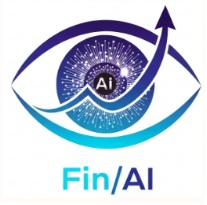